# 꽃 분류기

## 기본 모델

# 회고

**단순 컨브넷에서 이미지 증식과 드롭아웃을 포함한 컨브넷은 정확도 개선이 테스트 정확도 0.699에서 0.734로 3.5%P로 개선되었다. VGG16으로 훈련한 모델은 단순 컨브넷이나 이미지 증식 등을 결합한 컨브넷보다 높은 0.816의 테스트 정확도를 보이면서 개선된 성능을 보였다. 또한, 합성곱 기반층을 만들고 동결한 모델은 테스트 정확도 0.851로 큰 폭의 개선을 보였다. 다만, 사전 훈련된 모델의 미세조정은 추가적인 테스트 정확도 개선은 이루어지지 않았다.**

**VGG16 모델이 아닌 EfficientNet 모델을 도입해봤으며, 테스트 정확도는 0.940까지 큰 폭의 개선을 이루었다.**

In [1]:
import tensorflow as tf

tf.keras.backend.clear_session()

2024-08-12 16:15:33.523238: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-12 16:15:33.541538: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-12 16:15:33.541582: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-12 16:15:33.556319: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-12 16:15:35.041157: W tensorflow/compiler/tf

## 꽃 데이터셋 다운로드 및 train, validation, test 분류 저장

In [3]:
import tensorflow as tf
import pathlib

dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file(origin=dataset_url,
                                   fname='flower_photos',
                                   untar=True)
data_dir = pathlib.Path(data_dir)

print(f"Downloaded and extracted to: {data_dir}")


Downloaded and extracted to: /home/x/.keras/datasets/flower_photos


In [4]:
import pathlib
import shutil
import random
import os
from sklearn.model_selection import train_test_split

# 경로 설정
source_dir = pathlib.Path('/home/x/.keras/datasets/flower_photos')
target_dir = pathlib.Path('/home/x/myworks/keras/flower_photos')

# 폴더 구조 설정
train_dir = target_dir / 'train'
test_dir = target_dir / 'test'
val_dir = target_dir / 'validation'

# 필요한 폴더 생성
for directory in [train_dir, test_dir, val_dir]:
    for sub_dir in ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']:
        os.makedirs(directory / sub_dir, exist_ok=True)

# 데이터 분할 및 복사
categories = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

for category in categories:
    category_dir = source_dir / category
    all_images = list(category_dir.glob('*.*'))
    
    # 데이터 셋 분할
    train_images, temp_images = train_test_split(all_images, test_size=0.2, random_state=42)
    val_images, test_images = train_test_split(temp_images, test_size=0.5, random_state=42)

    # 데이터 복사
    for img in train_images:
        shutil.copy(img, train_dir / category)
    for img in val_images:
        shutil.copy(img, val_dir / category)
    for img in test_images:
        shutil.copy(img, test_dir / category)

print("Data has been split and saved successfully.")


Data has been split and saved successfully.


# 모델 만들기

**꽃 5가지 분류를 위한 소규모 컨브넷 만들기**

In [8]:
from tensorflow import keras
from tensorflow.keras import layers

inputs = keras.Input(shape=(180, 180, 3))
x = layers.Rescaling(1./255)(inputs)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
outputs = layers.Dense(5, activation="softmax")(x) # 5개 카테고리 반영
model = keras.Model(inputs=inputs, outputs=outputs)

In [9]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_1 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 18, 18, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 9, 9, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 7, 7, 256)      │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │        62,725 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,041,221 (3.97 MB)

 Trainable params: 1,041,221 (3.97 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.RMSprop(learning_rate=learning_rate),
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [2]:
from tensorflow.keras.utils import image_dataset_from_directory
import pathlib

new_base_dir = pathlib.Path("/home/x/myworks/keras/flower_photos")

train_dataset = image_dataset_from_directory(
    new_base_dir / "train",
    image_size=(180, 180),
    batch_size=32)
validation_dataset = image_dataset_from_directory(
    new_base_dir / "validation",
    image_size=(180, 180),
    batch_size=32)
test_dataset = image_dataset_from_directory(
    new_base_dir / "test",
    image_size=(180, 180),
    batch_size=32)

Found 2934 files belonging to 5 classes.


2024-08-12 16:15:43.011613: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-12 16:15:43.051637: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-12 16:15:43.051710: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-12 16:15:43.053656: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:984] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-12 16:15:43.053752: I external/local_xla/xla/stream_executor

Found 367 files belonging to 5 classes.
Found 369 files belonging to 5 classes.


In [3]:
print(train_dataset)

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 180, 180, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>


In [4]:
# 메타데이터 생성
metadata = {
    'class_names': train_dataset.class_names,
    'num_train_samples': tf.data.experimental.cardinality(train_dataset).numpy(),
    'num_validation_samples': tf.data.experimental.cardinality(validation_dataset).numpy(),
    'num_test_samples': tf.data.experimental.cardinality(test_dataset).numpy(),
    'image_size': (180, 180),
    'batch_size': 32
}

# 메타데이터 출력
print("메타데이터:", metadata)

메타데이터: {'class_names': ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips'], 'num_train_samples': 92, 'num_validation_samples': 12, 'num_test_samples': 12, 'image_size': (180, 180), 'batch_size': 32}


2024-08-12 16:15:57.874496: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


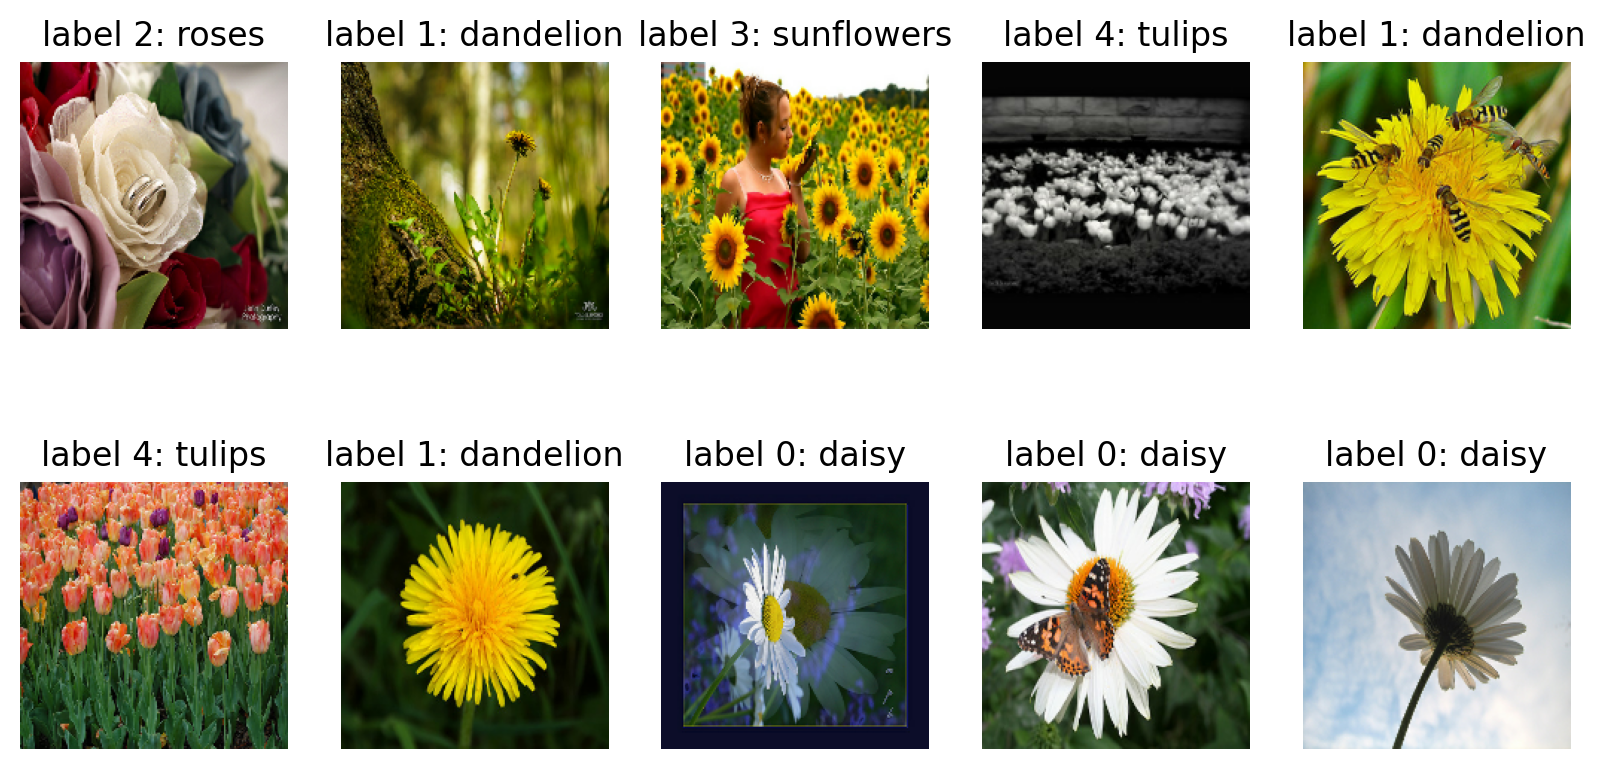

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# 클래스 이름을 metadata에서 직접 가져옵니다.
class_names = metadata['class_names']

plt.figure(figsize=(10, 5))

for idx, (image, label) in enumerate(train_dataset.take(10)):
    plt.subplot(2, 5, idx + 1)
    
    # 배치 차원을 제거합니다.
    image = image[0]  # image[0]은 첫 번째 이미지를 선택하여 배치 차원을 제거합니다.
    
    plt.imshow(image.numpy().astype("uint8"))  # 이미지를 NumPy 배열로 변환하여 표시
    plt.title(f'label {label[0]}: {class_names[label[0]]}')  # 첫 번째 라벨을 사용하여 클래스 이름으로 라벨 표시
    plt.axis('off')

plt.show()

In [16]:
import numpy as np
import tensorflow as tf
random_numbers = np.random.normal(size=(1000, 16))
dataset = tf.data.Dataset.from_tensor_slices(random_numbers)

In [17]:
for i, element in enumerate(dataset):
    print(element.shape)
    if i >= 2:
        break

(16,)
(16,)
(16,)


In [18]:
batched_dataset = dataset.batch(32)
for i, element in enumerate(batched_dataset):
    print(element.shape)
    if i >= 2:
        break

(32, 16)
(32, 16)
(32, 16)


In [19]:
reshaped_dataset = dataset.map(lambda x: tf.reshape(x, (4, 4)))
for i, element in enumerate(reshaped_dataset):
    print(element.shape)
    if i >= 2:
        break

(4, 4)
(4, 4)
(4, 4)


In [20]:
for data_batch, labels_batch in train_dataset:
    print("데이터 배치 크기:", data_batch.shape)
    print("레이블 배치 크기:", labels_batch.shape)
    break

데이터 배치 크기: (32, 180, 180, 3)
레이블 배치 크기: (32,)


In [21]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50


I0000 00:00:1723434933.912188   42345 service.cc:145] XLA service 0x7f31ac007fb0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1723434933.912271   42345 service.cc:153]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-08-12 12:55:33.996120: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-08-12 12:55:34.233422: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902


 5/92 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - accuracy: 0.2240 - loss: 1.6076

I0000 00:00:1723434946.331032   42345 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


92/92 ━━━━━━━━━━━━━━━━━━━━ 26s 135ms/step - accuracy: 0.3033 - loss: 1.5303 - val_accuracy: 0.4714 - val_loss: 1.2536
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - accuracy: 0.4557 - loss: 1.2436 - val_accuracy: 0.5095 - val_loss: 1.1743
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.5278 - loss: 1.1581 - val_accuracy: 0.5886 - val_loss: 1.0584
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 6s 43ms/step - accuracy: 0.5634 - loss: 1.0924 - val_accuracy: 0.5286 - val_loss: 1.0921
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 46ms/step - accuracy: 0.5793 - loss: 1.0504 - val_accuracy: 0.5422 - val_loss: 1.0839
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.5925 - loss: 1.0180 - val_accuracy: 0.5749 - val_loss: 0.9815
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.6053 - loss: 0.9890 - val_accuracy: 0.6049 - val_loss: 0.9877
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 47ms/step - accuracy: 0.6513 - loss: 0.9361 - val_accuracy: 0.6403 - val_loss: 

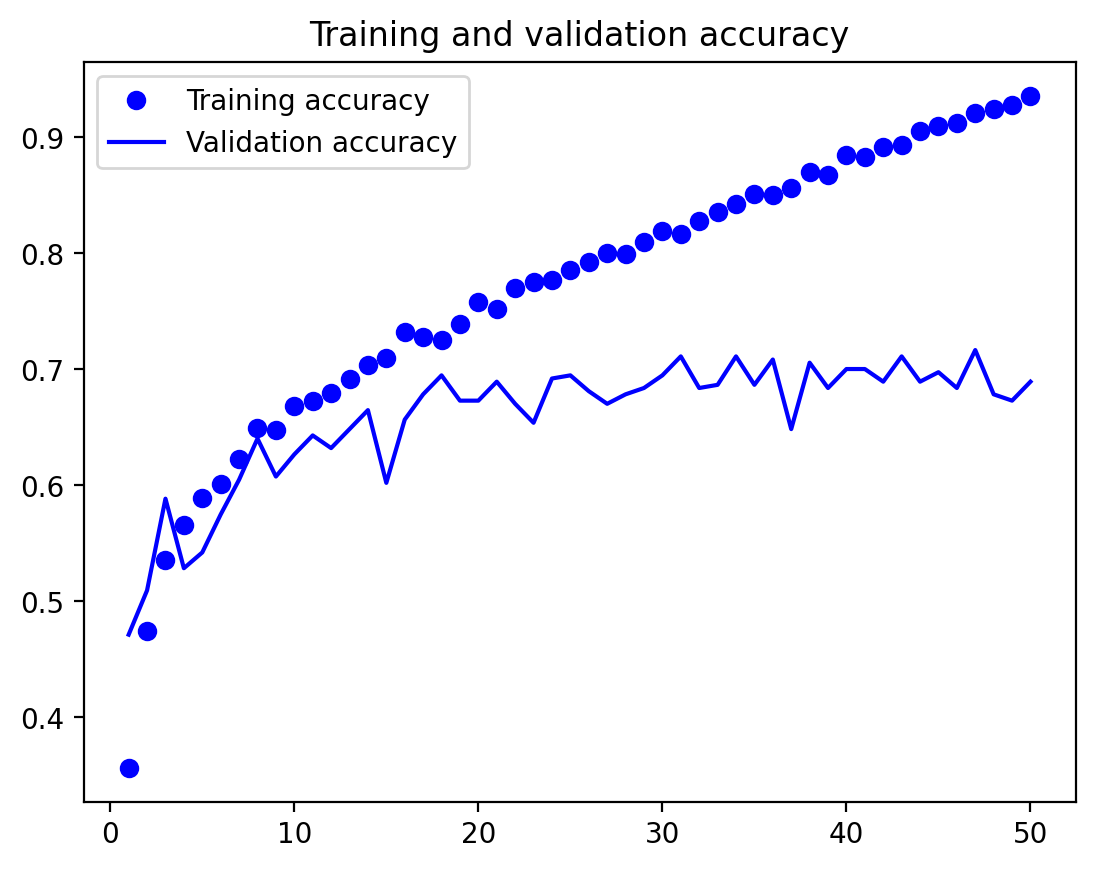

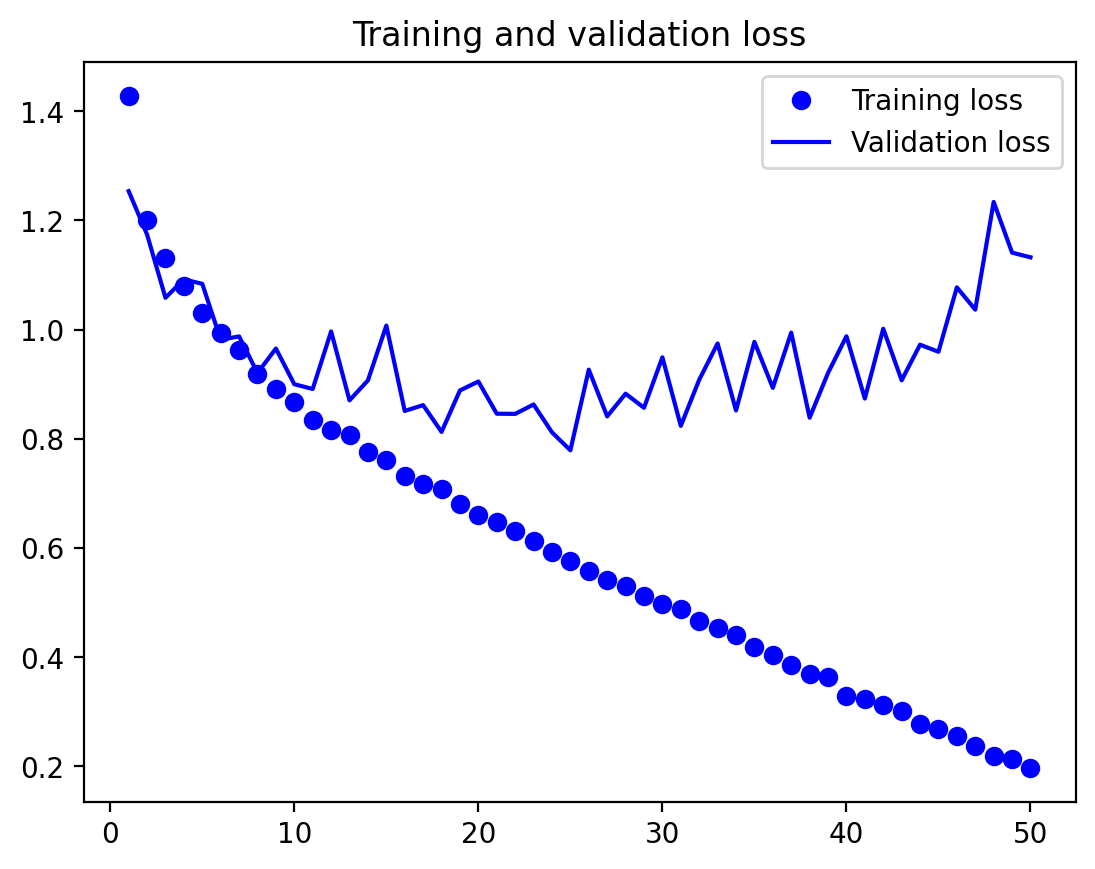

In [22]:
import matplotlib.pyplot as plt
accuracy = history.history["accuracy"]
val_accuracy = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(accuracy) + 1)
plt.plot(epochs, accuracy, "bo", label="Training accuracy")
plt.plot(epochs, val_accuracy, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [23]:
for image_batch, label_batch in test_dataset.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    break

predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 367ms/step


array([[1.2993827e-03, 3.3273706e-01, 3.8854510e-01, 5.0166994e-02,
        2.2725140e-01],
       [2.3832027e-02, 8.1243712e-01, 1.4123921e-01, 5.4902870e-05,
        2.2436753e-02],
       [7.2837516e-04, 7.1389956e-04, 3.0804253e-01, 3.9394534e-05,
        6.9047582e-01],
       [3.3868121e-03, 2.3010723e-06, 9.8334932e-01, 2.0429969e-04,
        1.3057256e-02],
       [1.4545042e-06, 4.7592075e-10, 5.7063168e-01, 1.3335543e-09,
        4.2936689e-01],
       [4.7014237e-13, 4.3193988e-13, 9.1253895e-01, 2.2594317e-10,
        8.7461092e-02],
       [7.3502618e-01, 9.3426304e-03, 2.4991840e-01, 3.0483613e-03,
        2.6645111e-03],
       [9.9999559e-01, 3.8970194e-07, 3.3504007e-06, 3.3660257e-08,
        7.3863129e-07],
       [5.5650831e-05, 2.4769843e-05, 1.3183104e-01, 3.2276600e-06,
        8.6808532e-01],
       [2.6828170e-01, 1.3496865e-01, 2.0518011e-01, 4.5219776e-03,
        3.8704759e-01],
       [1.2433349e-08, 1.3522718e-03, 1.2016123e-06, 9.8999780e-01,
        8.64

In [24]:
predictions = np.argmax(predictions, axis=1)
predictions

array([2, 1, 4, 2, 2, 2, 0, 0, 4, 4, 3, 1, 0, 4, 2, 4, 0, 0, 0, 4, 3, 4,
       4, 4, 2, 1, 4, 0, 1, 1, 1, 4])

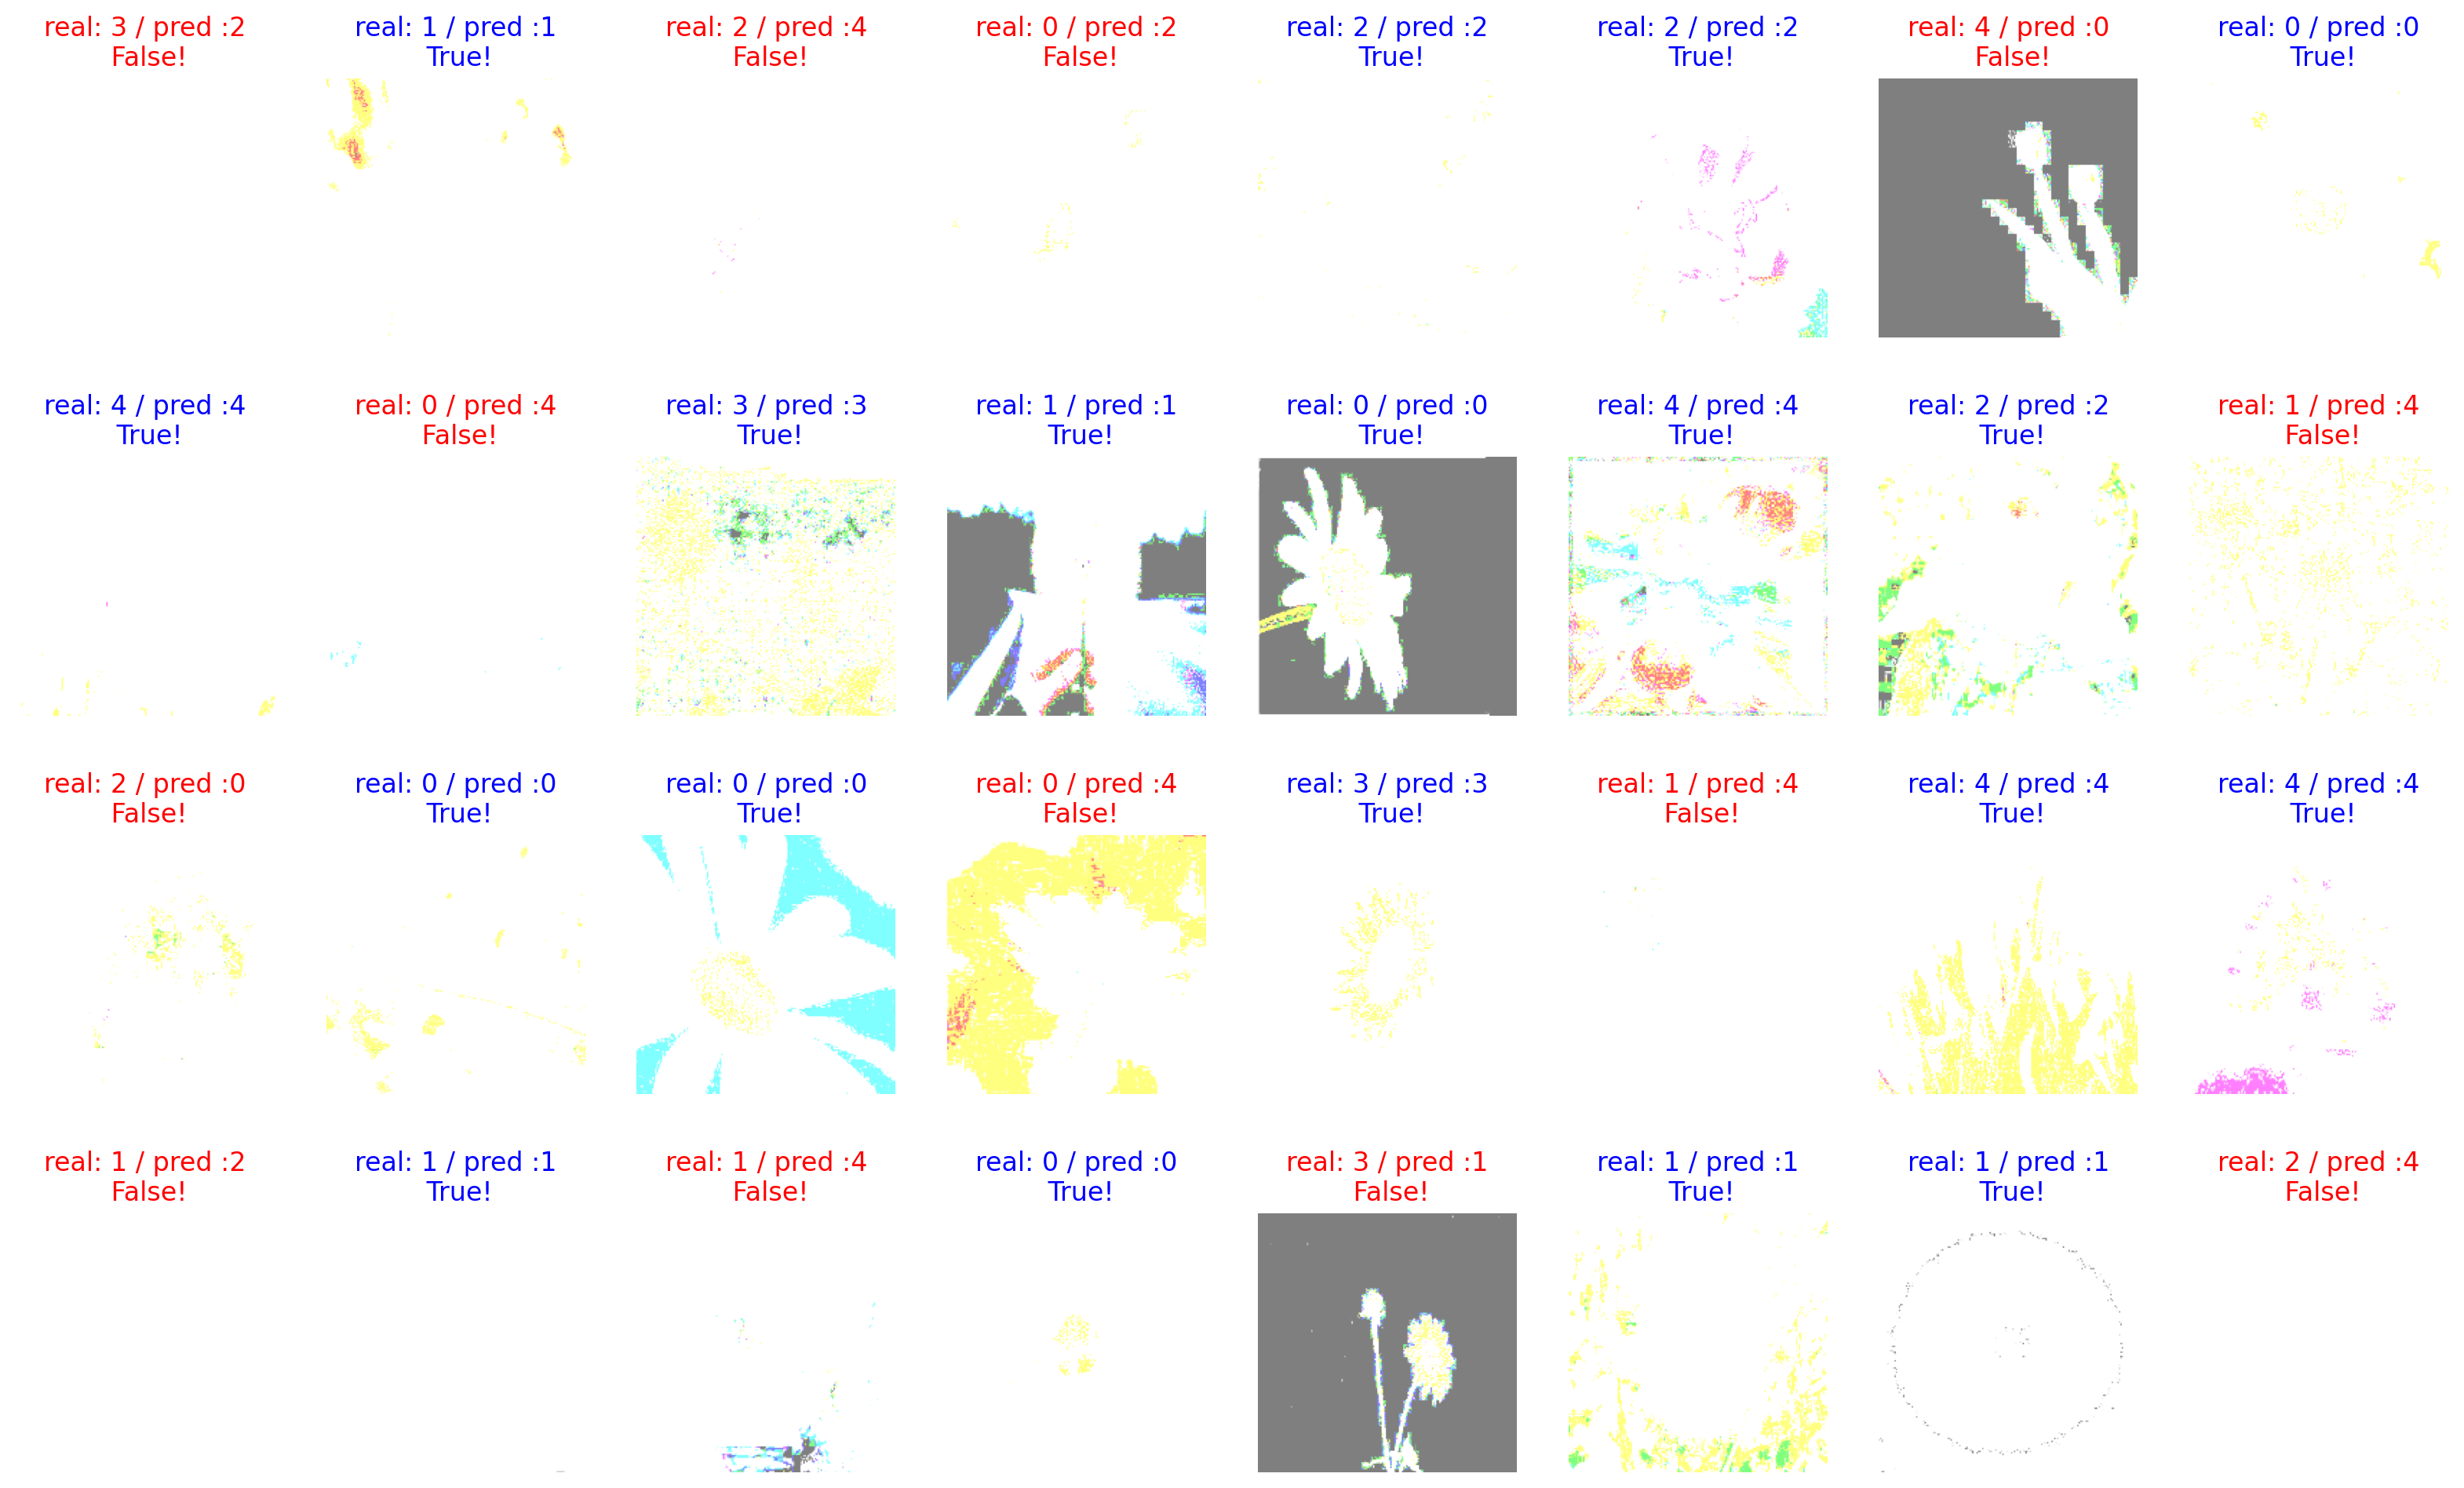

In [25]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

In [26]:
test_model = keras.models.load_model("convnet_from_scratch.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"테스트 정확도: {test_acc:.3f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 110ms/step - accuracy: 0.6649 - loss: 0.8706
테스트 정확도: 0.699


## 데이터 증식 사용

In [27]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

2024-08-12 13:31:53.110179: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


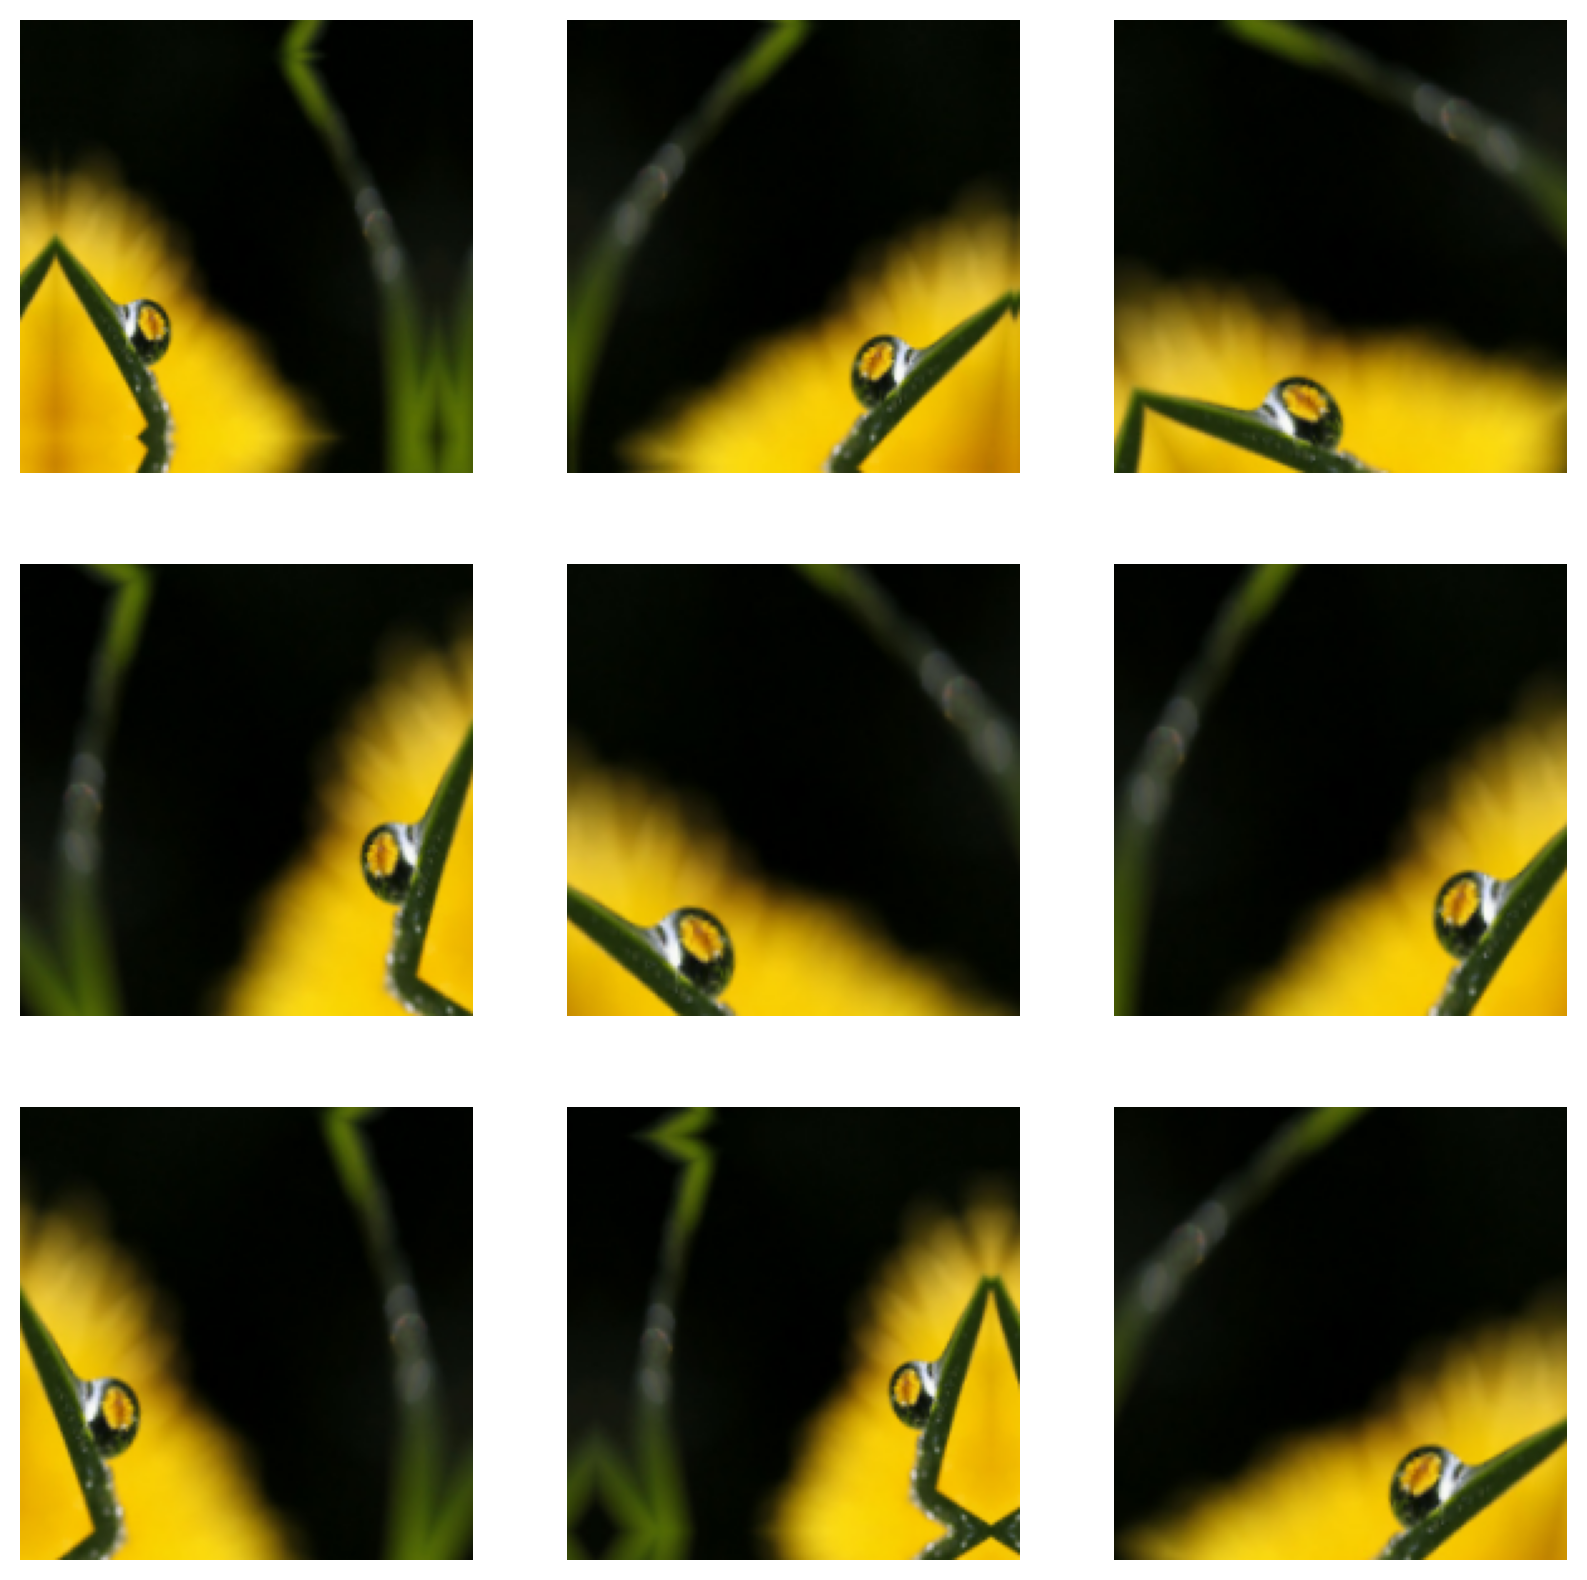

In [28]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

**이미지 증식과 드롭아웃을 포함한 컨브넷 만들기**

In [29]:
inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = layers.Rescaling(1./255)(x)
x = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=64, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=128, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.MaxPooling2D(pool_size=2)(x)
x = layers.Conv2D(filters=256, kernel_size=3, activation="relu")(x)
x = layers.Flatten()(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation="softmax")(x)
model = keras.Model(inputs=inputs, outputs=outputs)

model.compile(optimizer="rmsprop",
              loss=tf.keras.losses.sparse_categorical_crossentropy,
              metrics=['accuracy'])

In [56]:
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 5, 5, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 256)            │     3,277,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,556,684 (25.01 MB)

 Trainable params: 3,278,341 (12.51 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,278,343 (12.51 MB)

In [30]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="convnet_from_scratch_with_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 13s 87ms/step - accuracy: 0.2718 - loss: 1.8916 - val_accuracy: 0.4441 - val_loss: 1.2189
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.4482 - loss: 1.2890 - val_accuracy: 0.5749 - val_loss: 1.1598
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 48ms/step - accuracy: 0.5313 - loss: 1.1243 - val_accuracy: 0.5068 - val_loss: 1.7749
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 4s 39ms/step - accuracy: 0.5906 - loss: 1.1030 - val_accuracy: 0.6022 - val_loss: 0.9435
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.6255 - loss: 0.9851 - val_accuracy: 0.6240 - val_loss: 0.9813
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 48ms/step - accuracy: 0.6555 - loss: 0.9043 - val_accuracy: 0.6649 - val_loss: 0.8826
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 51ms/step - accuracy: 0.6917 - loss: 0.8299 - val_accuracy: 0.6485 - val_loss: 0.8391
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 5s 49ms/step - accuracy: 0.6829 - loss: 0.8233 - val_accuracy: 0.6975 - 

In [31]:
test_model = keras.models.load_model(
    "convnet_from_scratch_with_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"테스트 정확도: {test_acc:.3f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.7441 - loss: 0.6156
테스트 정확도: 0.734


In [32]:
conv_base = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False,
    input_shape=(180, 180, 3))

In [33]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 180, 180, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 180, 180, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 90, 90, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 90, 90, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 90, 90, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 45, 45, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 45, 45, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 45, 45, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 22, 22, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 22, 22, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 22, 22, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 11, 11, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 11, 11, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 5, 5, 512)      │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

**VGG16 특성과 해당 레이블 추출하기**

In [34]:
import numpy as np

def get_features_and_labels(dataset):
    all_features = []
    all_labels = []
    for images, labels in dataset:
        preprocessed_images = keras.applications.vgg16.preprocess_input(images)
        features = conv_base.predict(preprocessed_images)
        all_features.append(features)
        all_labels.append(labels)
    return np.concatenate(all_features), np.concatenate(all_labels)

train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 8s 8s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━

2024-08-12 13:49:40.160490: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step


2024-08-12 13:49:46.902722: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step


2024-08-12 13:49:53.222933: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [35]:
train_features.shape

(2934, 5, 5, 512)

In [37]:
inputs = keras.Input(shape=(5, 5, 512))
x = layers.Flatten()(inputs)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation="softmax")(x) # 5개 카테고리
model = keras.Model(inputs, outputs)
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer="rmsprop",
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
      filepath="feature_extraction.keras",
      save_best_only=True,
      monitor="val_loss")
]
history = model.fit(
    train_features, train_labels,
    epochs=50,
    validation_data=(val_features, val_labels),
    callbacks=callbacks)

Epoch 1/50


I0000 00:00:1723438478.541794   60828 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_573', 32 bytes spill stores, 32 bytes spill loads

I0000 00:00:1723438478.990507   60830 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_573', 40 bytes spill stores, 40 bytes spill loads

I0000 00:00:1723438479.434004   60829 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_573', 4 bytes spill stores, 4 bytes spill loads



89/92 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.6558 - loss: 43.5674

I0000 00:00:1723438482.671062   60891 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_573', 40 bytes spill stores, 40 bytes spill loads

I0000 00:00:1723438483.366521   60888 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_573', 32 bytes spill stores, 32 bytes spill loads

I0000 00:00:1723438483.611129   60889 asm_compiler.cc:369] ptxas warning : Registers are spilled to local memory in function 'triton_gemm_dot_573', 4 bytes spill stores, 4 bytes spill loads



92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 71ms/step - accuracy: 0.6589 - loss: 43.0636 - val_accuracy: 0.8311 - val_loss: 16.1359
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8881 - loss: 8.2028 - val_accuracy: 0.8447 - val_loss: 23.9549
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9294 - loss: 4.5981 - val_accuracy: 0.8610 - val_loss: 20.1642
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9466 - loss: 4.1586 - val_accuracy: 0.8447 - val_loss: 21.5534
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9511 - loss: 3.4476 - val_accuracy: 0.8311 - val_loss: 20.9928
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9679 - loss: 2.1834 - val_accuracy: 0.8447 - val_loss: 23.3354
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9679 - loss: 2.3312 - val_accuracy: 0.8256 - val_loss: 27.8559
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9812 - loss: 1.3262 - val_accuracy: 0.8392 - val_loss: 

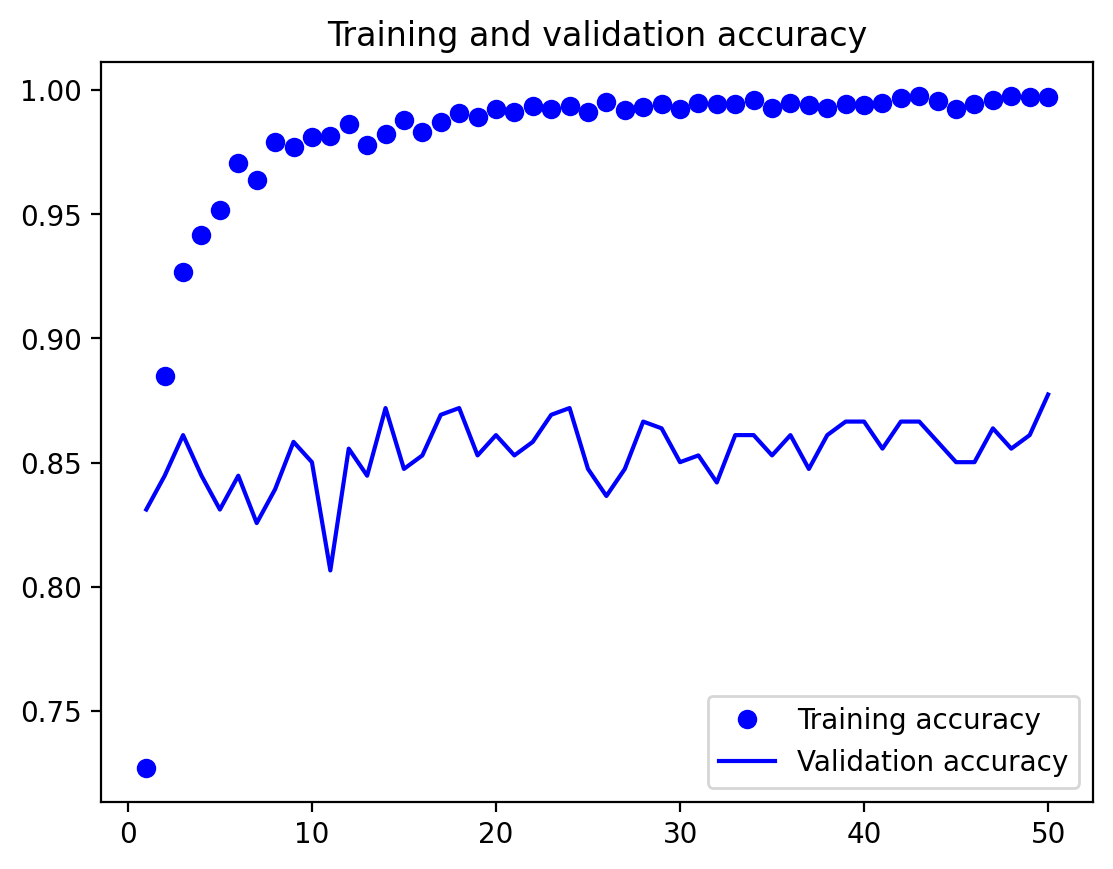

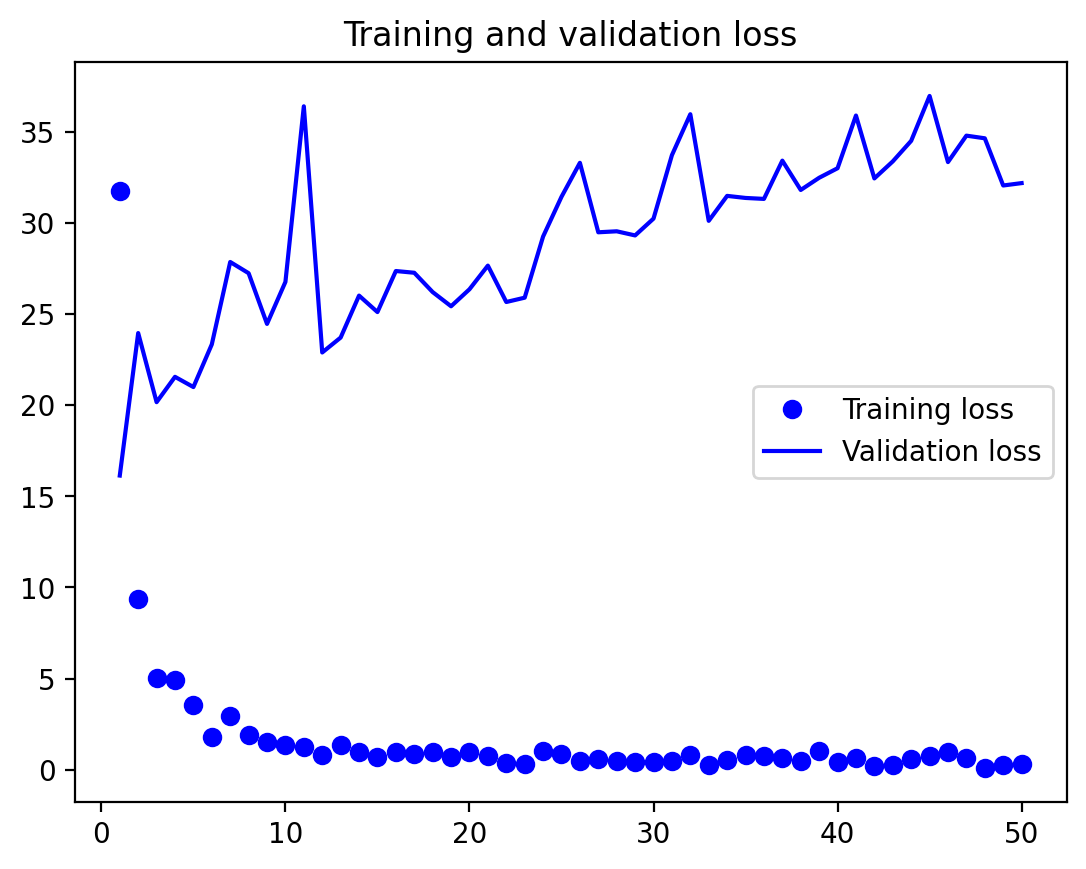

In [38]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [39]:
test_model = keras.models.load_model(
    "feature_extraction.keras")
test_loss, test_acc = test_model.evaluate(test_features,test_labels)
print(f"테스트 정확도: {test_acc:.3f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 113ms/step - accuracy: 0.7963 - loss: 19.9412
테스트 정확도: 0.816


In [54]:
# TensorFlow 데이터셋 객체인지 확인
print(type(test_features))

<class 'numpy.ndarray'>


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
Predicted class: [2]


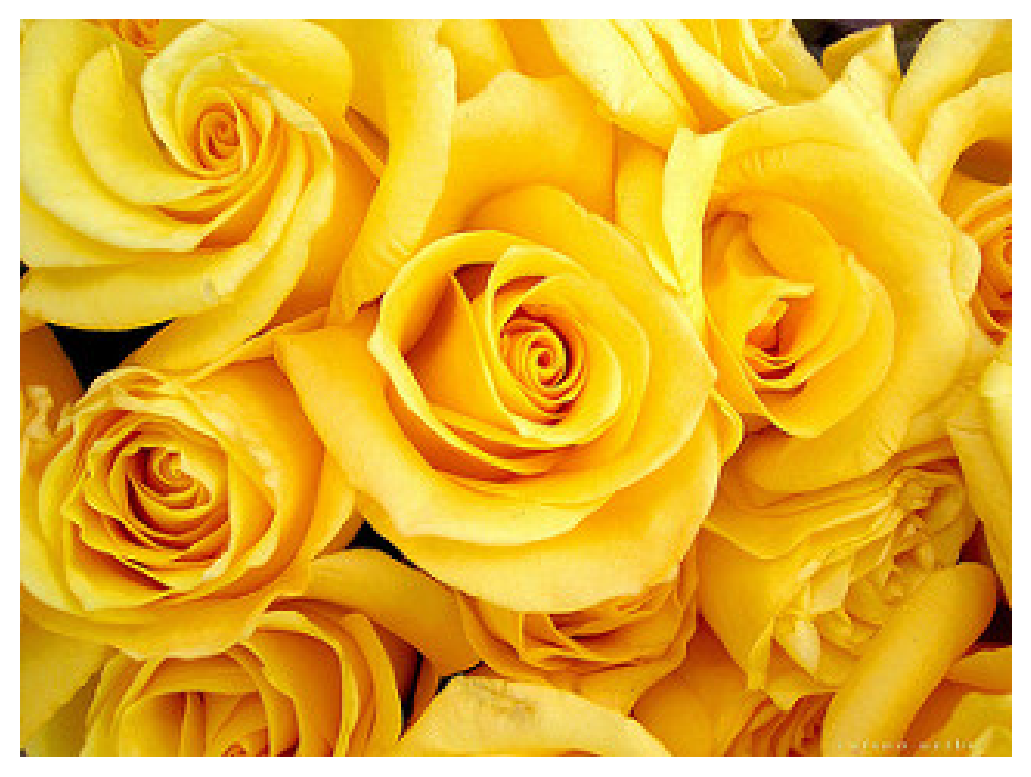

In [65]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

# 이미지 전처리 함수 정의
def preprocess_image(image_path):
    # 이미지 로드 및 리사이즈
    img = load_img(image_path, target_size=(5, 5))
    img_array = img_to_array(img)

    # 채널 확장 (3채널 이미지를 512채널로 확장)
    repeat_count = 512 // img_array.shape[2]
    remainder = 512 % img_array.shape[2]
    
    # 반복하여 채널을 512로 확장
    img_array = np.tile(img_array, (1, 1, repeat_count))
    
    # 필요한 경우, 나머지 채널을 추가
    if remainder > 0:
        img_array = np.concatenate((img_array, img_array[:, :, :remainder]), axis=2)
    
    # 배치 차원 추가
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# 예시 이미지 경로 (이미지의 실제 경로로 교체해야 함)
test_image_path = "/home/x/myworks/keras/flower_photos/test/roses/145862135_ab710de93c_n.jpg"
test_image = preprocess_image(test_image_path)

# 예측
# 모델의 입력 형태와 맞게 변환한 이미지의 차원을 (5, 5, 512)로 변경해야 함
# 여기서는 단순히 예시를 들기 위한 것으로, 실제 데이터의 전처리 및 변환이 필요할 수 있음

# 예측을 수행
predictions = model.predict(test_image)
predicted_class = np.argmax(predictions, axis=-1)

print(f"Predicted class: {predicted_class}")

# 이미지 로드 함수
def display_image(image_path):
    img = load_img(image_path)  # 이미지 로드
    plt.imshow(img)  # 이미지를 화면에 표시
    plt.axis('off')  # 축 제거
    plt.show()

# 이미지 표시
display_image(test_image_path)

#### 데이터 증식을 사용한 특성 추출

**VGG16 합성곱 기반 층을 만들고 동결하기**

In [67]:
conv_base  = keras.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False)
conv_base.trainable = False

In [68]:
conv_base.trainable = True
print("합성곱 기반 층을 동결하기 전의 훈련 가능한 가중치 개수:",
      len(conv_base.trainable_weights))

합성곱 기반 층을 동결하기 전의 훈련 가능한 가중치 개수: 26


In [69]:
conv_base.trainable = False
print("합성곱 기반 층을 동결한 후의 훈련 가능한 가중치 개수:",
      len(conv_base.trainable_weights))

합성곱 기반 층을 동결한 후의 훈련 가능한 가중치 개수: 0


In [70]:
data_augmentation = keras.Sequential(
    [
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.1),
        layers.RandomZoom(0.2),
    ]
)

inputs = keras.Input(shape=(180, 180, 3))
x = data_augmentation(inputs)
x = keras.applications.vgg16.preprocess_input(x)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(5, activation="softmax")(x)
model = keras.Model(inputs, outputs)
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer="rmsprop",
              metrics=["accuracy"])

In [71]:
model.summary()

Model: "functional_10"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential_1        │ (None, 180, 180,  │          0 │ input_layer_8[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item (GetItem)  │ (None, 180, 180)  │          0 │ sequential_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_1          │ (None, 180, 180)  │          0 │ sequential_1[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ get_item_2          │ (None, 180, 180)  │          0 │ sequential_1[0][… │
│ (GetItem)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stack (Stack)       │ (None, 180, 180,  │          0 │ get_item[0][0],   │
│                     │ 3)                │            │ get_item_1[0][0], │
│                     │                   │            │ get_item_2[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 180, 180,  │          0 │ stack[0][0]       │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 5, 5, 512) │ 14,714,688 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_5 (Flatten) │ (None, 12800)     │          0 │ vgg16[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 256)       │  3,277,056 │ flatten_5[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 256)       │          0 │ dense_7[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 5)         │      1,285 │ dropout_3[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 17,993,029 (68.64 MB)

 Trainable params: 3,278,341 (12.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [72]:
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="feature_extraction_with_data_augmentation.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 21s 184ms/step - accuracy: 0.6123 - loss: 45.6185 - val_accuracy: 0.7847 - val_loss: 19.1353
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 173ms/step - accuracy: 0.8073 - loss: 17.2850 - val_accuracy: 0.8256 - val_loss: 18.7995
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 177ms/step - accuracy: 0.8385 - loss: 12.2936 - val_accuracy: 0.8338 - val_loss: 19.3654
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 15s 166ms/step - accuracy: 0.8452 - loss: 10.8038 - val_accuracy: 0.8229 - val_loss: 21.6366
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 186ms/step - accuracy: 0.8750 - loss: 8.2343 - val_accuracy: 0.8120 - val_loss: 21.3784
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 16s 172ms/step - accuracy: 0.8572 - loss: 10.2218 - val_accuracy: 0.8365 - val_loss: 18.2344
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 205ms/step - accuracy: 0.8753 - loss: 7.6942 - val_accuracy: 0.8120 - val_loss: 18.0678
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 198ms/step - accuracy: 0.8910 - loss: 5.944

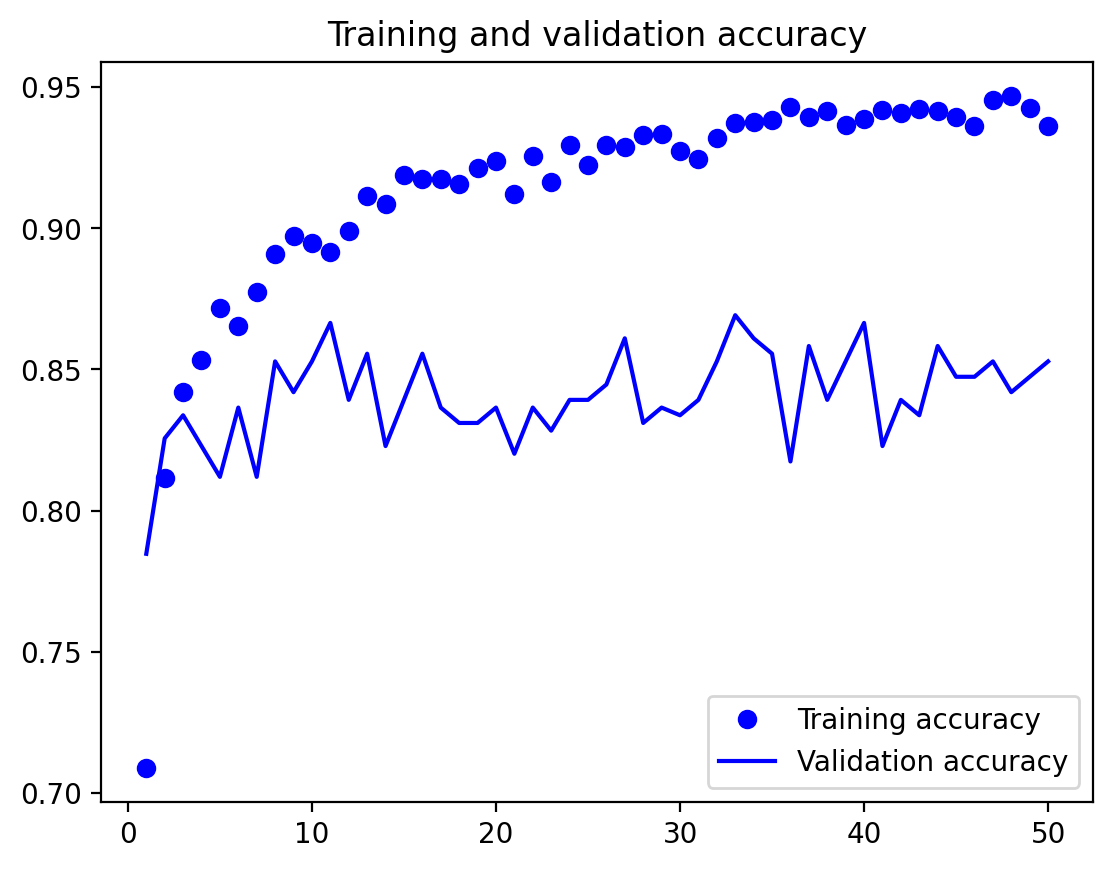

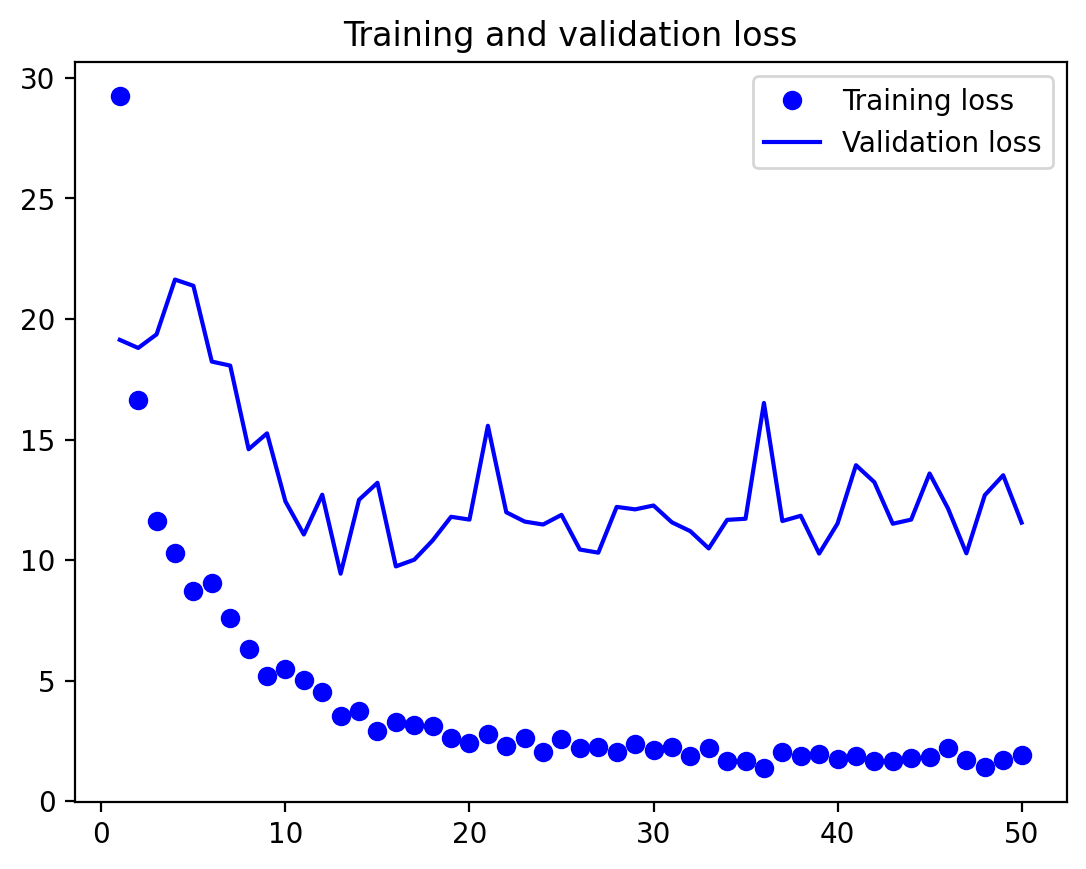

In [73]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [74]:
test_model = keras.models.load_model(
    "feature_extraction_with_data_augmentation.keras")
test_loss, test_acc = test_model.evaluate(test_dataset)
print(f"테스트 정확도: {test_acc:.3f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 6s 437ms/step - accuracy: 0.8615 - loss: 15.2551
테스트 정확도: 0.851


### 사전 훈련된 모델 미세 조정하기

In [75]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 14,714,688 (56.13 MB)

In [76]:
conv_base.trainable = True
for layer in conv_base.layers[:-4]:
    layer.trainable = False

In [77]:
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath="fine_tuning.keras",
        save_best_only=True,
        monitor="val_loss")
]
history = model.fit(
    train_dataset,
    epochs=30,
    validation_data=validation_dataset,
    callbacks=callbacks)

Epoch 1/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 28s 216ms/step - accuracy: 0.9428 - loss: 1.5931 - val_accuracy: 0.8638 - val_loss: 11.4038
Epoch 2/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 205ms/step - accuracy: 0.9554 - loss: 1.3698 - val_accuracy: 0.8556 - val_loss: 13.1860
Epoch 3/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 18s 200ms/step - accuracy: 0.9630 - loss: 0.8186 - val_accuracy: 0.8774 - val_loss: 10.3274
Epoch 4/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 207ms/step - accuracy: 0.9716 - loss: 0.7053 - val_accuracy: 0.8556 - val_loss: 9.4909
Epoch 5/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 207ms/step - accuracy: 0.9770 - loss: 0.5426 - val_accuracy: 0.8583 - val_loss: 10.4182
Epoch 6/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 205ms/step - accuracy: 0.9715 - loss: 0.5840 - val_accuracy: 0.8638 - val_loss: 9.1025
Epoch 7/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 19s 202ms/step - accuracy: 0.9696 - loss: 0.6545 - val_accuracy: 0.8774 - val_loss: 9.0654
Epoch 8/30
92/92 ━━━━━━━━━━━━━━━━━━━━ 17s 181ms/step - accuracy: 0.9756 - loss: 0.5784 - val_

In [78]:
model = keras.models.load_model("fine_tuning.keras")
test_loss, test_acc = model.evaluate(test_dataset)
print(f"테스트 정확도: {test_acc:.3f}")

12/12 ━━━━━━━━━━━━━━━━━━━━ 2s 72ms/step - accuracy: 0.8672 - loss: 7.9657
테스트 정확도: 0.846


# EfficientNet 모델

In [18]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy
from tensorflow.keras.metrics import SparseCategoricalAccuracy

# EfficientNetB0 모델 불러오기 (사전 훈련된 가중치 사용)
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(180, 180, 3))

# 모델 구조 설정
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(5, activation='softmax')(x)  # 5개의 클래스

# 전체 모델 정의
model = Model(inputs=base_model.input, outputs=predictions)

# 모델 컴파일
model.compile(loss=tf.keras.losses.sparse_categorical_crossentropy,
              optimizer=keras.optimizers.RMSprop(learning_rate=1e-5),
              metrics=["accuracy"])

model.summary()

# 모델 학습
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=50
)

# 모델 평가
loss, accuracy = model.evaluate(test_dataset)
print(f"Test accuracy: {accuracy:.3f}")

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 180, 180,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_6         │ (None, 180, 180,  │          0 │ input_layer_3[0]… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization_3     │ (None, 180, 180,  │          7 │ rescaling_6[0][0] │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling_7         │ (None, 180, 180,  │          0 │ normalization_3[… │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv_pad       │ (None, 181, 181,  │          0 │ rescaling_7[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 90, 90,    │        864 │ stem_conv_pad[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 90, 90,    │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 90, 90,    │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_dwconv      │ (None, 90, 90,    │        288 │ stem_activation[… │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_bn          │ (None, 90, 90,    │        128 │ block1a_dwconv[0… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_activation  │ (None, 90, 90,    │          0 │ block1a_bn[0][0]  │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_squeeze  │ (None, 32)        │          0 │ block1a_activati… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reshape  │ (None, 1, 1, 32)  │          0 │ block1a_se_squee… │
│ (Reshape)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_reduce   │ (None, 1, 1, 8)   │        264 │ block1a_se_resha… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_expand   │ (None, 1, 1, 32)  │        288 │ block1a_se_reduc… │
│ (Conv2D)            │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_se_excite   │ (None, 90, 90,    │          0 │ block1a_activati… │
│ (Multiply)          │ 32)               │            │ block1a_se_expan… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 90, 90,    │        512 │ block1a_se_excit

 Total params: 5,366,440 (20.47 MB)

 Trainable params: 5,324,417 (20.31 MB)

 Non-trainable params: 42,023 (164.16 KB)

Epoch 1/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 180s 1s/step - accuracy: 0.3544 - loss: 1.5132 - val_accuracy: 0.6921 - val_loss: 1.1549
Epoch 2/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 14s 146ms/step - accuracy: 0.7382 - loss: 1.1140 - val_accuracy: 0.8202 - val_loss: 0.8095
Epoch 3/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 12s 126ms/step - accuracy: 0.8242 - loss: 0.8213 - val_accuracy: 0.8692 - val_loss: 0.6006
Epoch 4/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 111ms/step - accuracy: 0.8497 - loss: 0.6102 - val_accuracy: 0.8801 - val_loss: 0.4767
Epoch 5/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - accuracy: 0.8745 - loss: 0.4822 - val_accuracy: 0.8937 - val_loss: 0.4007
Epoch 6/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 125ms/step - accuracy: 0.8891 - loss: 0.4118 - val_accuracy: 0.9046 - val_loss: 0.3529
Epoch 7/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 10s 109ms/step - accuracy: 0.8984 - loss: 0.3520 - val_accuracy: 0.9183 - val_loss: 0.3190
Epoch 8/50
92/92 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - accuracy: 0.9265 - loss: 0.2901 - val_accura

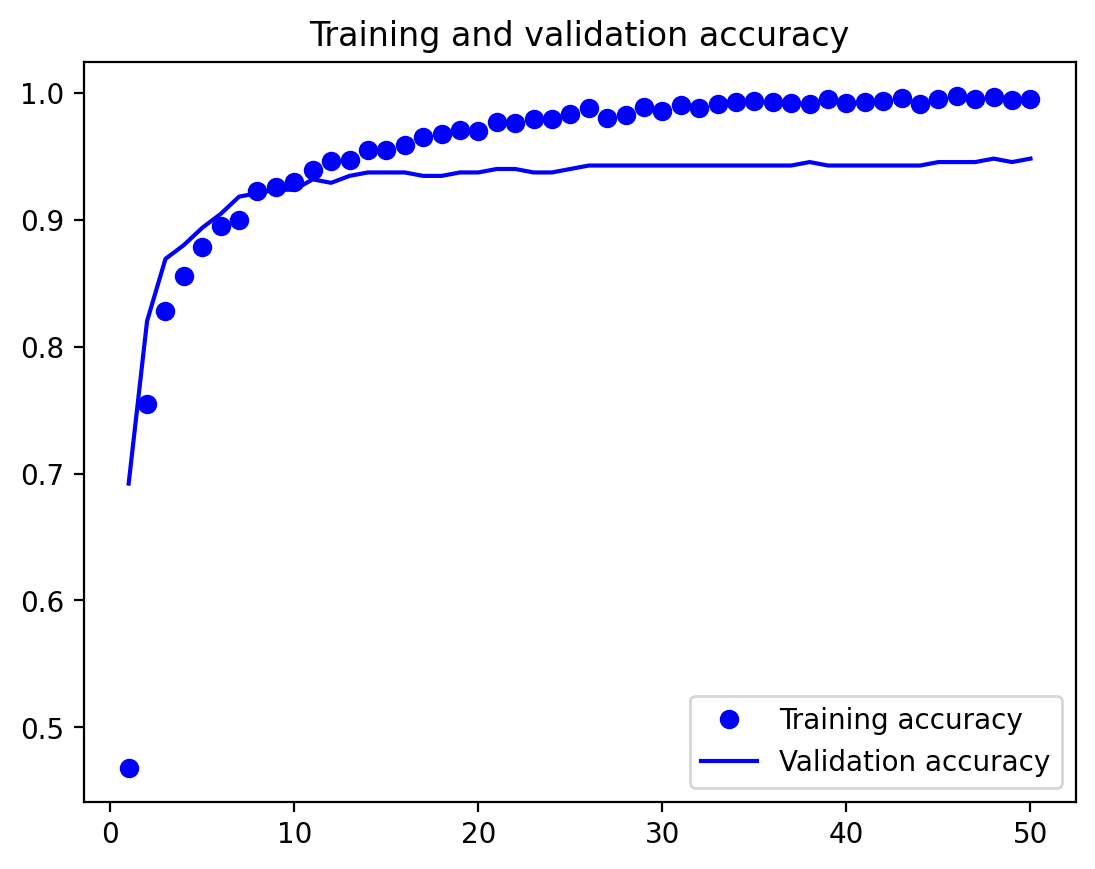

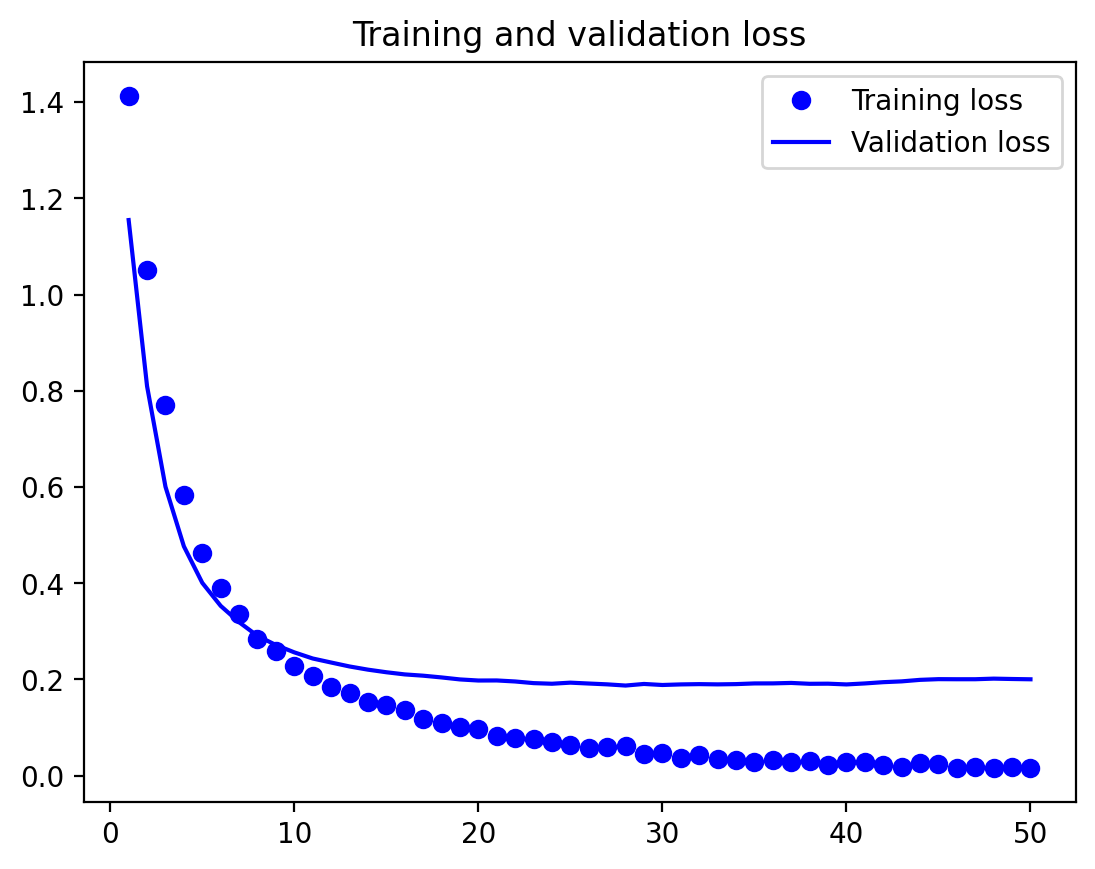

In [19]:
import matplotlib.pyplot as plt
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]
loss = history.history["loss"]
val_loss = history.history["val_loss"]
epochs = range(1, len(acc) + 1)
plt.plot(epochs, acc, "bo", label="Training accuracy")
plt.plot(epochs, val_acc, "b", label="Validation accuracy")
plt.title("Training and validation accuracy")
plt.legend()
plt.figure()
plt.plot(epochs, loss, "bo", label="Training loss")
plt.plot(epochs, val_loss, "b", label="Validation loss")
plt.title("Training and validation loss")
plt.legend()
plt.show()

In [20]:
for image_batch, label_batch in test_dataset.take(1):
    images = image_batch
    labels = label_batch
    predictions = model.predict(image_batch)
    break

predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step


array([[2.33657920e-04, 9.60779260e-04, 1.29765409e-04, 9.98640001e-01,
        3.57779354e-05],
       [9.99997616e-01, 1.80385848e-06, 1.14430328e-07, 1.81047213e-07,
        2.95282263e-07],
       [1.30358212e-05, 6.51113951e-05, 7.85371140e-06, 9.99869227e-01,
        4.46681952e-05],
       [6.63551109e-05, 6.38511337e-05, 3.98791544e-02, 6.81234960e-05,
        9.59922493e-01],
       [2.75600378e-08, 5.01053563e-08, 1.36280121e-07, 3.53612194e-07,
        9.99999404e-01],
       [1.04068744e-03, 1.21997669e-04, 6.01833761e-01, 2.03078853e-05,
        3.96983266e-01],
       [9.99452531e-01, 3.84148007e-05, 1.54990397e-04, 2.24007788e-04,
        1.30081447e-04],
       [6.82298123e-05, 9.99851704e-01, 4.80744120e-06, 5.91971184e-05,
        1.60879063e-05],
       [1.30065814e-06, 3.08604308e-06, 3.35480445e-06, 9.99990225e-01,
        2.01975990e-06],
       [9.99828577e-01, 1.09698827e-04, 3.90124733e-05, 1.65310928e-06,
        2.11048391e-05],
       [1.57555711e-04, 1.8298

In [21]:
import numpy as np

predictions = np.argmax(predictions, axis=1)
predictions

array([3, 0, 3, 4, 4, 2, 0, 1, 3, 0, 3, 0, 1, 1, 0, 2, 3, 1, 2, 1, 1, 4,
       3, 0, 2, 4, 1, 0, 3, 4, 1, 3])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

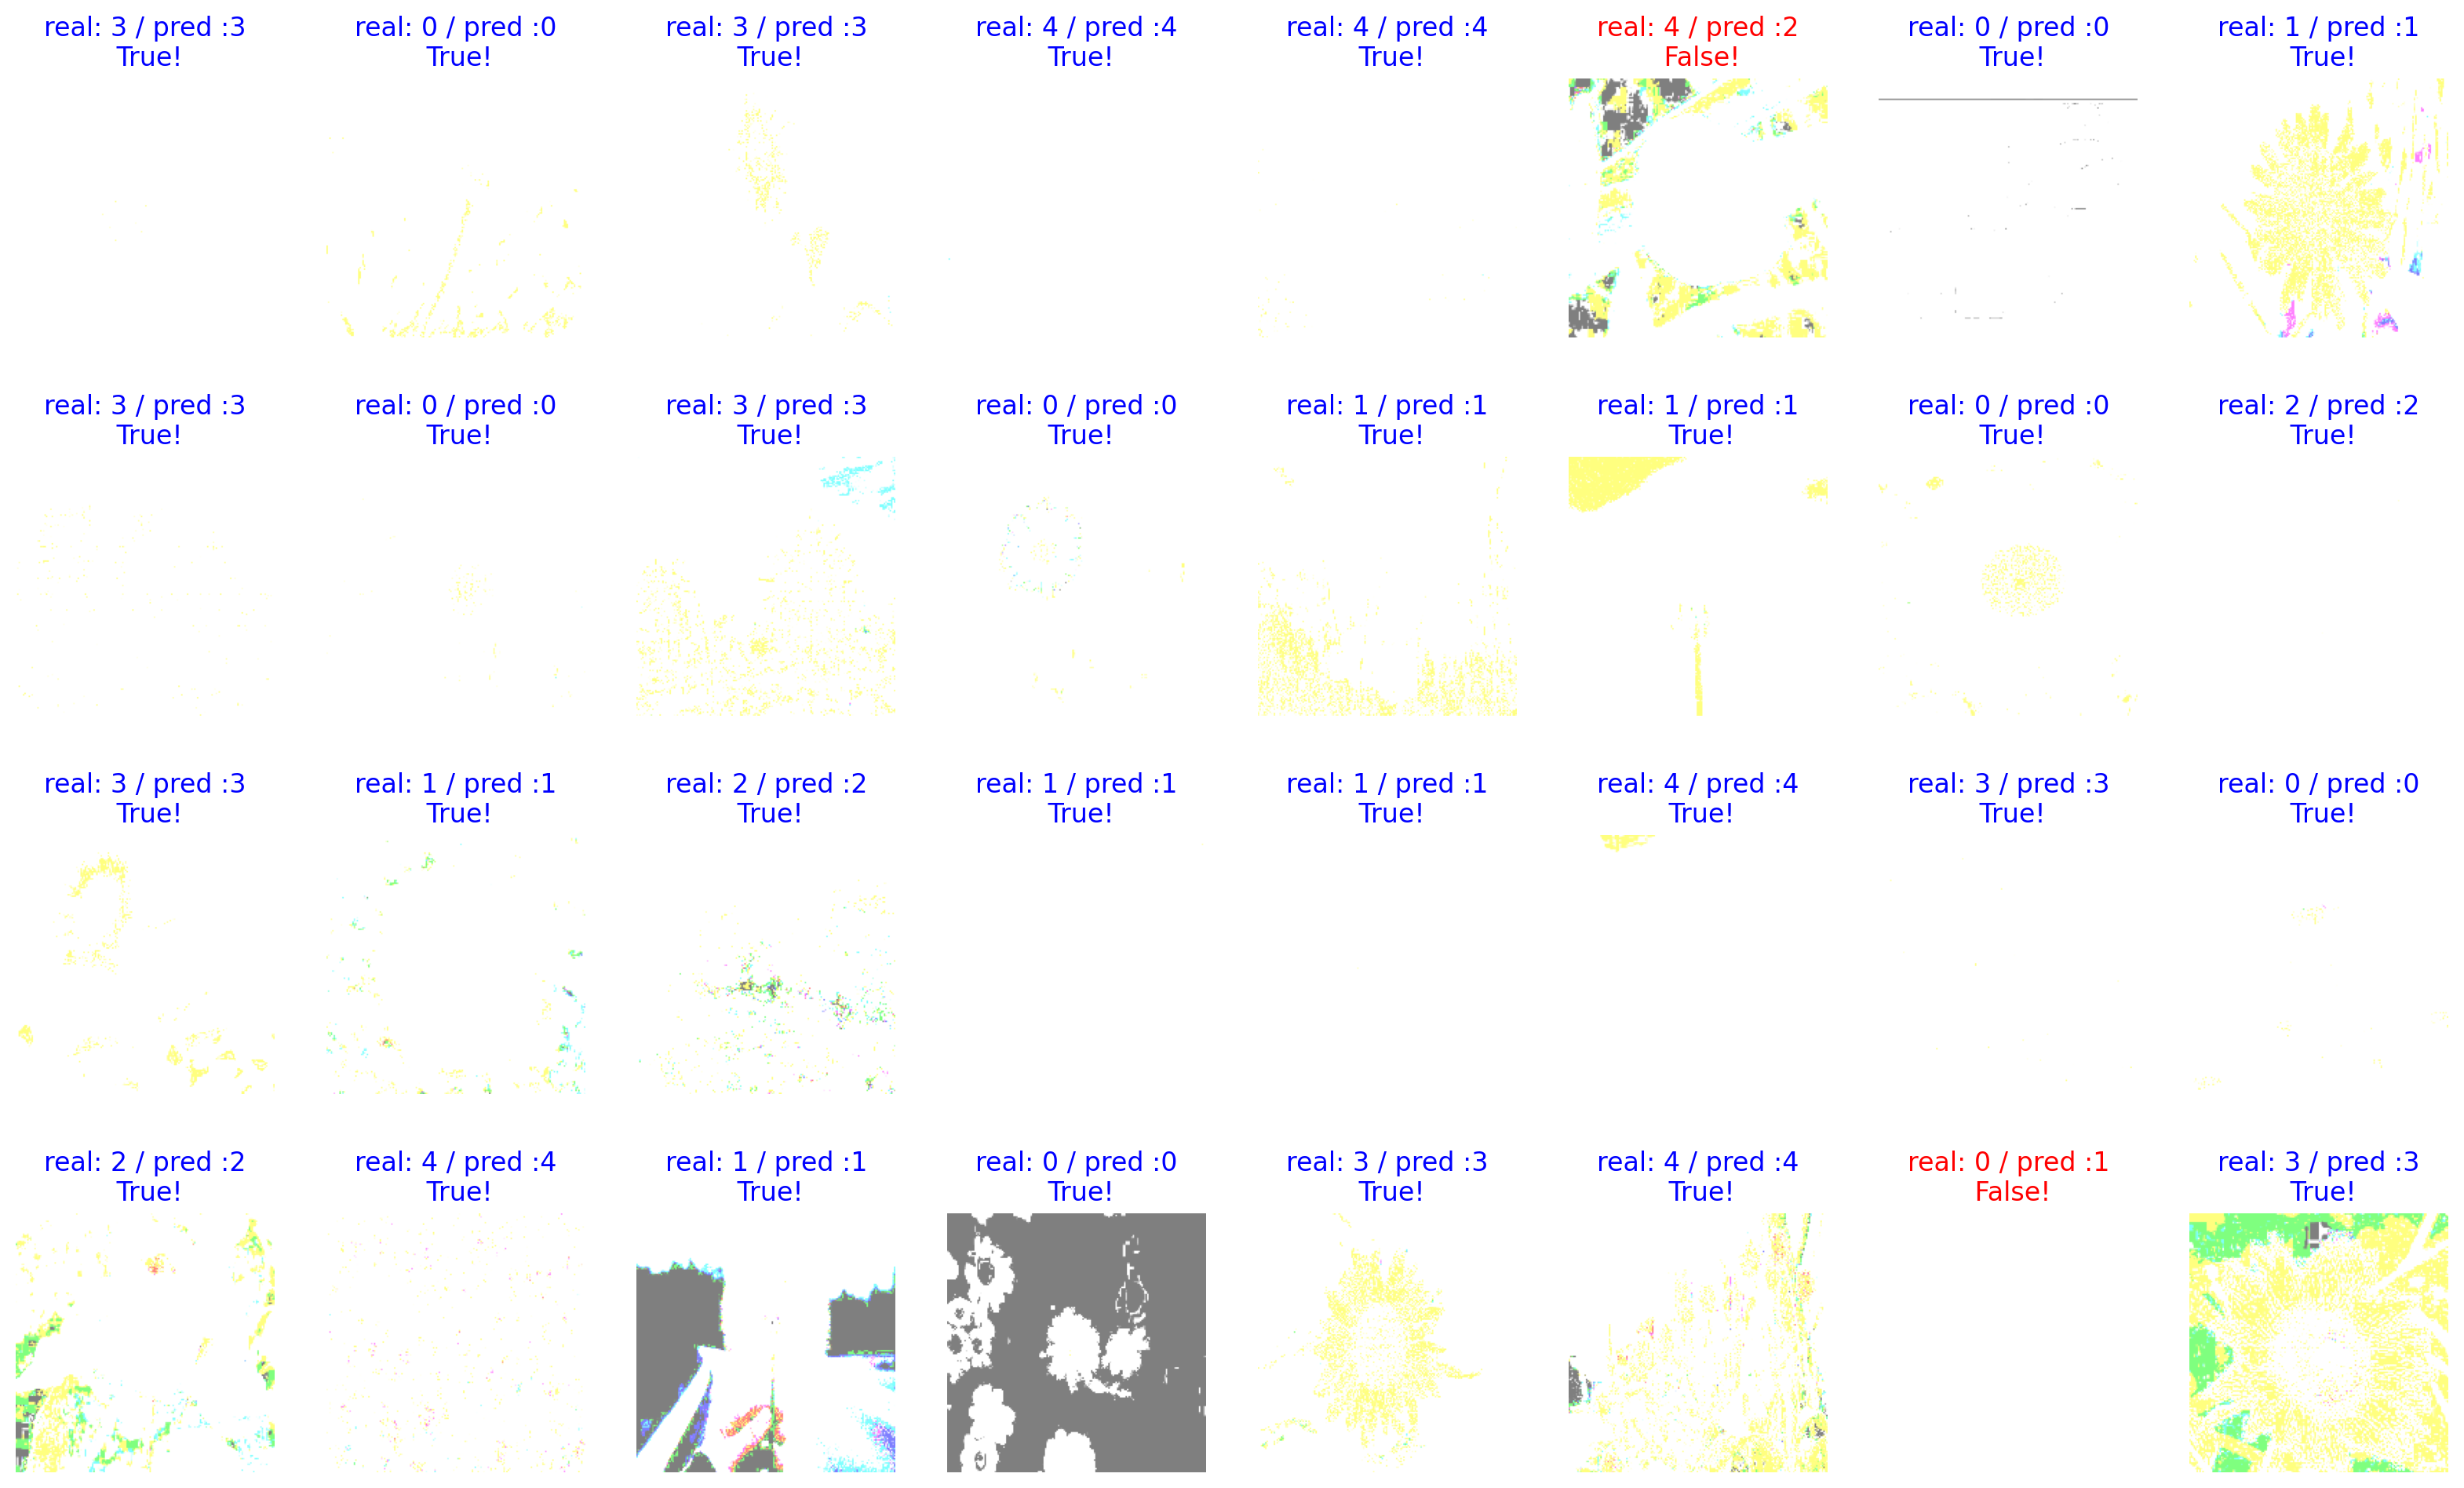

In [22]:
plt.figure(figsize=(20, 12))

for idx, (image, label, prediction) in enumerate(zip(images, labels, predictions)):
    plt.subplot(4, 8, idx+1)
    image = (image + 1) / 2
    plt.imshow(image)
    correct = label == prediction
    title = f'real: {label} / pred :{prediction}\n {correct}!'
    if not correct:
        plt.title(title, fontdict={'color': 'red'})
    else:
        plt.title(title, fontdict={'color': 'blue'})
    plt.axis('off')

# 요약
- 소규모 컨브넷: 0.699
- 이미지 증식과 드롭아웃을 포함한 컨브넷: 0.734
- VGG16 특성과 레이블 추출: 0.816
- VGG16 합성곱 기반 층을 만들고 동결: 0.851
- VGG16 사전 훈련된 모델 미세조정: 0.846
- EfficientNet 모델: 0.940